# 🚀 DeepMost Agentic SDR - Advanced Analytics Suite

**Production-Grade EDA for Sales AI Startups**

This notebook provides comprehensive analysis including:
- 📊 Statistical Analysis & Hypothesis Testing
- 🧠 NLP & Conversation Analytics
- 🤖 ML Model Development & Evaluation
- 📈 Business Metrics & KPIs
- 🔬 A/B Testing Framework

---

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import warnings
from pathlib import Path
from datetime import datetime
from collections import Counter
import re

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Statistical imports
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

warnings.filterwarnings('ignore')

# Try different matplotlib styles
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('ggplot')

# Paths - works from notebooks directory
DATA_DIR = Path('../data/processed')
CONVERSATIONS_DIR = Path('../data/raw/conversations')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


## 1. 📁 Data Loading & Quality Assessment

In [2]:
# Load all datasets
try:
    master_df = pd.read_csv(DATA_DIR / 'simulations_master.csv')
    turns_df = pd.read_csv(DATA_DIR / 'conversation_turns.csv')
    metrics_df = pd.read_csv(DATA_DIR / 'simulation_metrics.csv')
    
    print("📊 Data Loaded Successfully!")
    print(f"   • Master Records: {len(master_df):,}")
    print(f"   • Conversation Turns: {len(turns_df):,}")
    print(f"   • Metrics Records: {len(metrics_df):,}")
    print(f"   • Unique Conversations: {metrics_df['simulation_id'].nunique():,}")
    DATA_LOADED = True
except FileNotFoundError as e:
    print("⚠️ Data files not found. Run simulations first!")
    print("   Execute: python main.py")
    print(f"   Error: {e}")
    DATA_LOADED = False
    # Create empty dataframes to prevent errors
    metrics_df = pd.DataFrame()
    turns_df = pd.DataFrame()
    master_df = pd.DataFrame()

📊 Data Loaded Successfully!
   • Master Records: 31
   • Conversation Turns: 216
   • Metrics Records: 30
   • Unique Conversations: 30


In [3]:
# Data Quality Report
def data_quality_report(df, name):
    if df.empty:
        print(f"⚠️ {name} is empty. Run simulations first!")
        return None
    
    print(f"\n{'='*50}")
    print(f"📋 Data Quality Report: {name}")
    print(f"{'='*50}")
    
    total = len(df)
    print(f"\nTotal Records: {total:,}")
    
    # Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / total * 100).round(2)
    
    if missing.sum() > 0:
        print("\n⚠️ Missing Values:")
        for col in missing[missing > 0].index:
            print(f"   • {col}: {missing[col]} ({missing_pct[col]}%)")
    else:
        print("\n✅ No missing values!")
    
    # Duplicates
    dupes = df.duplicated().sum()
    print(f"\nDuplicate rows: {dupes}")
    
    return df.describe(include='all')

if DATA_LOADED:
    data_quality_report(metrics_df, 'Simulation Metrics')


📋 Data Quality Report: Simulation Metrics

Total Records: 30

✅ No missing values!

Duplicate rows: 0


## 2. 📈 Business Metrics Dashboard

In [4]:
# Calculate core KPIs
def calculate_kpis(df):
    if df.empty:
        return {}
    kpis = {
        'Total Simulations': len(df),
        'Success Rate': f"{df['outcome_binary'].mean()*100:.1f}%",
        'Average Score': f"{df['score'].mean():.2f}/10",
        'Median Score': df['score'].median(),
        'Avg Conversation Length': f"{df['total_conversation_length'].mean():.0f} words",
        'Avg Turns per Call': f"{df['num_turns'].mean():.1f}",
        'Seller Talk Ratio': f"{df['word_ratio_seller_buyer'].mean():.2f}",
    }
    return kpis

if DATA_LOADED:
    kpis = calculate_kpis(metrics_df)
    print("🎯 KEY PERFORMANCE INDICATORS")
    print("="*40)
    for k, v in kpis.items():
        print(f"{k}: {v}")
else:
    print("⚠️ No data available. Run simulations first!")

🎯 KEY PERFORMANCE INDICATORS
Total Simulations: 30
Success Rate: 16.7%
Average Score: 3.70/10
Median Score: 3.0
Avg Conversation Length: 420 words
Avg Turns per Call: 3.2
Seller Talk Ratio: 1.82


In [5]:
# Interactive KPI Dashboard
if DATA_LOADED and len(metrics_df) > 0:
    fig = make_subplots(
        rows=2, cols=3,
        specs=[
            [{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}],
            [{'type': 'pie'}, {'type': 'histogram'}, {'type': 'scatter'}]
        ],
        subplot_titles=['', '', '', 'Outcome Distribution', 'Score Distribution', 'Length vs Score']
    )

    # KPI Gauges
    win_rate = metrics_df['outcome_binary'].mean() * 100
    fig.add_trace(go.Indicator(
        mode="gauge+number+delta",
        value=win_rate,
        title={'text': "Win Rate %"},
        delta={'reference': 50},
        gauge={'axis': {'range': [0, 100]},
               'bar': {'color': 'green' if win_rate > 50 else 'red'}}
    ), row=1, col=1)

    fig.add_trace(go.Indicator(
        mode="number+delta",
        value=metrics_df['score'].mean(),
        title={'text': "Avg Score"},
        delta={'reference': 5}
    ), row=1, col=2)

    fig.add_trace(go.Indicator(
        mode="number",
        value=len(metrics_df),
        title={'text': "Total Simulations"}
    ), row=1, col=3)

    # Outcome Pie
    outcome_counts = metrics_df['outcome_label'].value_counts()
    fig.add_trace(go.Pie(
        labels=outcome_counts.index.tolist(),
        values=outcome_counts.values.tolist(),
        marker_colors=['#2ecc71', '#e74c3c', '#f39c12']
    ), row=2, col=1)

    # Score Histogram
    fig.add_trace(go.Histogram(
        x=metrics_df['score'].tolist(),
        nbinsx=10,
        marker_color='#3498db'
    ), row=2, col=2)

    # Length vs Score Scatter
    colors = ['green' if x == 1 else 'red' for x in metrics_df['outcome_binary']]
    fig.add_trace(go.Scatter(
        x=metrics_df['total_conversation_length'].tolist(),
        y=metrics_df['score'].tolist(),
        mode='markers',
        marker=dict(color=colors, size=10, opacity=0.6)
    ), row=2, col=3)

    fig.update_layout(height=800, title_text="📊 Business Metrics Dashboard", showlegend=False)
    fig.show()
else:
    print("⚠️ No data available for dashboard")

## 3. 🧠 NLP & Conversation Analytics

In [6]:
# Sentiment Analysis using lexicon
POSITIVE_WORDS = {'yes', 'great', 'interested', 'love', 'perfect', 'amazing', 'definitely', 
                  'absolutely', 'excellent', 'wonderful', 'impressive', 'excited'}
NEGATIVE_WORDS = {'no', 'not', 'expensive', 'busy', 'later', 'problem', 'issue', 'concern',
                  'difficult', 'impossible', 'reject', 'decline', 'competitor'}

def analyze_sentiment(text):
    """Simple lexicon-based sentiment."""
    if not isinstance(text, str):
        return 'neutral', 0
    words = text.lower().split()
    pos = sum(1 for w in words if w in POSITIVE_WORDS)
    neg = sum(1 for w in words if w in NEGATIVE_WORDS)
    
    if pos > neg:
        return 'positive', (pos - neg) / max(len(words), 1)
    elif neg > pos:
        return 'negative', (neg - pos) / max(len(words), 1)
    return 'neutral', 0

if DATA_LOADED and len(turns_df) > 0 and 'message' in turns_df.columns:
    # Apply to turns
    sentiment_results = turns_df['message'].apply(analyze_sentiment)
    turns_df['sentiment_label'] = [r[0] for r in sentiment_results]
    turns_df['sentiment_score'] = [r[1] for r in sentiment_results]

    # Sentiment by speaker
    sentiment_by_speaker = turns_df.groupby(['speaker', 'sentiment_label']).size().unstack(fill_value=0)

    fig = px.bar(sentiment_by_speaker.reset_index().melt(id_vars='speaker'),
                 x='speaker', y='value', color='sentiment_label',
                 barmode='group', title='Sentiment Distribution by Speaker',
                 color_discrete_map={'positive': 'green', 'negative': 'red', 'neutral': 'gray'})
    fig.show()
else:
    print("⚠️ No conversation data available for sentiment analysis")

In [7]:
# Objection Analysis
OBJECTION_KEYWORDS = {
    'Price': ['expensive', 'cost', 'budget', 'price', 'afford', 'money', 'cheap'],
    'Timing': ['busy', 'time', 'later', 'timing', 'schedule', 'quarter'],
    'Authority': ['boss', 'team', 'decide', 'approval', 'committee', 'manager'],
    'Need': ['need', 'solution', 'already', 'current', 'existing'],
    'Trust': ['risk', 'prove', 'guarantee', 'reference', 'case study']
}

def detect_objections(text):
    if not isinstance(text, str):
        return []
    text_lower = text.lower()
    detected = []
    for obj_type, keywords in OBJECTION_KEYWORDS.items():
        if any(kw in text_lower for kw in keywords):
            detected.append(obj_type)
    return detected

if DATA_LOADED and len(turns_df) > 0 and 'message' in turns_df.columns:
    # Analyze buyer messages for objections
    buyer_turns = turns_df[turns_df['speaker'] == 'Buyer'].copy()
    buyer_turns['objections'] = buyer_turns['message'].apply(detect_objections)

    # Flatten and count
    all_objections = [obj for objlist in buyer_turns['objections'] for obj in objlist]
    objection_counts = Counter(all_objections)

    print("🎯 Objection Frequency Analysis")
    print("="*40)
    if objection_counts:
        for obj, count in objection_counts.most_common():
            print(f"{obj}: {count} occurrences")
    else:
        print("No objections detected in conversations")
else:
    print("⚠️ No data available for objection analysis")

🎯 Objection Frequency Analysis
Need: 84 occurrences
Price: 30 occurrences
Timing: 23 occurrences
Trust: 16 occurrences
Authority: 13 occurrences


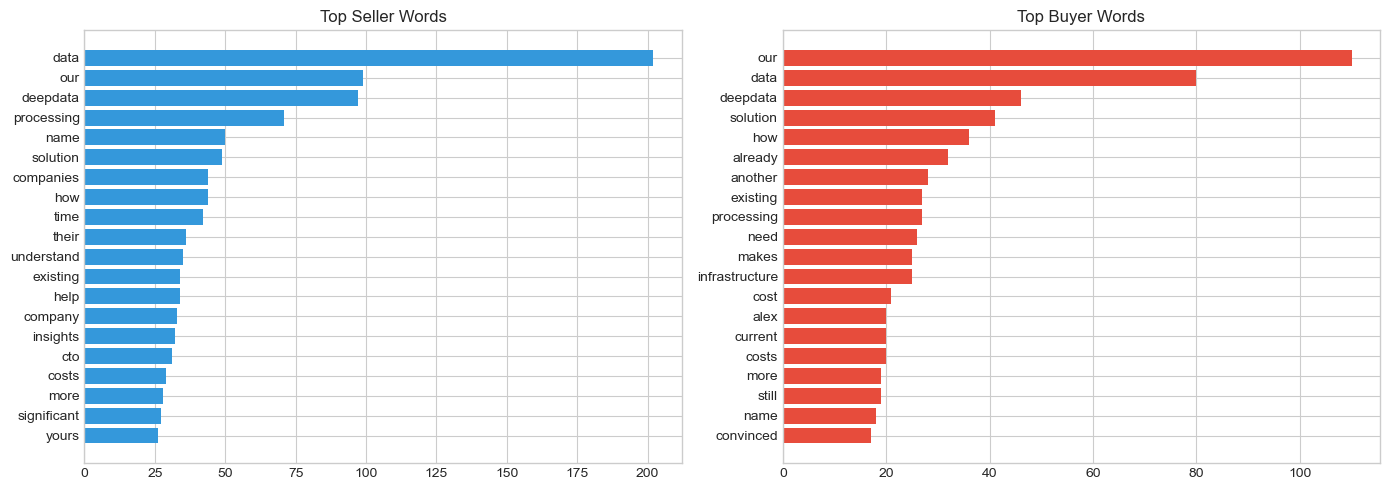

In [8]:
# Word Frequency Analysis
def get_word_freq(texts, top_n=20):
    """Get top N words from a list of texts."""
    all_text = ' '.join([str(t) for t in texts]).lower()
    words = re.findall(r'\b[a-z]{3,}\b', all_text)
    # Remove stop words
    stop_words = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 
                  'your', 'have', 'been', 'will', 'with', 'this', 'that', 'from',
                  'would', 'could', 'should', 'about', 'what', 'just', 'like'}
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(top_n)

if DATA_LOADED and len(turns_df) > 0 and 'message' in turns_df.columns:
    # Word frequency by speaker
    seller_words = get_word_freq(turns_df[turns_df['speaker'] == 'Seller']['message'])
    buyer_words = get_word_freq(turns_df[turns_df['speaker'] == 'Buyer']['message'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Seller words
    if seller_words:
        words, counts = zip(*seller_words)
        axes[0].barh(words, counts, color='#3498db')
        axes[0].set_title('Top Seller Words')
        axes[0].invert_yaxis()
    else:
        axes[0].text(0.5, 0.5, 'No seller data', ha='center', va='center')

    # Buyer words
    if buyer_words:
        words, counts = zip(*buyer_words)
        axes[1].barh(words, counts, color='#e74c3c')
        axes[1].set_title('Top Buyer Words')
        axes[1].invert_yaxis()
    else:
        axes[1].text(0.5, 0.5, 'No buyer data', ha='center', va='center')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No data available for word frequency analysis")

## 4. 📊 Statistical Analysis & Hypothesis Testing

In [9]:
# Compare successful vs failed calls
def statistical_comparison(success_df, failure_df, column):
    """Perform statistical comparison between success and failure groups."""
    success_vals = success_df[column].dropna()
    failure_vals = failure_df[column].dropna()
    
    if len(success_vals) < 2 or len(failure_vals) < 2:
        return {
            'column': column,
            'success_mean': success_vals.mean() if len(success_vals) > 0 else None,
            'failure_mean': failure_vals.mean() if len(failure_vals) > 0 else None,
            'difference': None,
            't_statistic': None,
            't_pvalue': None,
            'significant': None
        }
    
    # T-test
    t_stat, t_pval = ttest_ind(success_vals, failure_vals)
    
    return {
        'column': column,
        'success_mean': success_vals.mean(),
        'failure_mean': failure_vals.mean(),
        'difference': success_vals.mean() - failure_vals.mean(),
        't_statistic': t_stat,
        't_pvalue': t_pval,
        'significant': t_pval < 0.05 if t_pval is not None else None
    }

if DATA_LOADED and len(metrics_df) > 0:
    success = metrics_df[metrics_df['outcome_binary'] == 1]
    failure = metrics_df[metrics_df['outcome_binary'] == 0]
    
    # Test key metrics
    metrics_to_test = ['total_conversation_length', 'word_ratio_seller_buyer', 
                       'seller_avg_words_per_turn', 'buyer_avg_words_per_turn']
    
    # Filter to only existing columns
    metrics_to_test = [m for m in metrics_to_test if m in metrics_df.columns]
    
    if metrics_to_test and len(success) > 0 and len(failure) > 0:
        results = [statistical_comparison(success, failure, col) for col in metrics_to_test]
        results_df = pd.DataFrame(results)
        
        print("📊 Statistical Comparison: Success vs Failure")
        print("="*60)
        display(results_df.round(4))
    else:
        print("⚠️ Need both success and failure cases for comparison")
else:
    print("⚠️ No data available for statistical analysis")

📊 Statistical Comparison: Success vs Failure


,column,success_mean,failure_mean,difference,t_statistic,t_pvalue,significant
0,total_conversation_length,392.800,425.7600,-32.9600,-0.8772,0.3879,False
1,word_ratio_seller_buyer,1.488,1.8864,-0.3984,-1.7542,0.0903,False
2,seller_avg_words_per_turn,63.550,73.8800,-10.3300,-1.3983,0.1730,False
3,buyer_avg_words_per_turn,47.516,47.9932,-0.4772,-0.0979,0.9227,False


In [10]:
# Chi-Square Test for Objection vs Outcome
if DATA_LOADED and len(metrics_df) > 0 and 'objection_type' in metrics_df.columns:
    try:
        contingency = pd.crosstab(metrics_df['objection_type'], metrics_df['outcome_label'])
        
        if contingency.shape[0] >= 2 and contingency.shape[1] >= 2:
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            
            print("🔬 Chi-Square Test: Objection Type vs Outcome")
            print("="*50)
            print(f"Chi-Square Statistic: {chi2:.4f}")
            print(f"P-Value: {p_value:.4f}")
            print(f"Degrees of Freedom: {dof}")
            print(f"\n{'✅ Significant association!' if p_value < 0.05 else '❌ No significant association'}")
            
            # Visualize
            fig = px.imshow(contingency, text_auto=True, aspect='auto',
                            title='Objection Type vs Outcome Heatmap',
                            color_continuous_scale='RdYlGn')
            fig.show()
        else:
            print("⚠️ Need at least 2 categories in each variable for chi-square test")
            print(f"Current shape: {contingency.shape}")
    except Exception as e:
        print(f"⚠️ Chi-square test failed: {e}")
else:
    print("⚠️ No objection data available for analysis")

🔬 Chi-Square Test: Objection Type vs Outcome
Chi-Square Statistic: 53.4750
P-Value: 0.0000
Degrees of Freedom: 10

✅ Significant association!


## 5. 🤖 Machine Learning Models

In [11]:
# Prepare features
if DATA_LOADED and len(metrics_df) > 0:
    feature_cols = [
        'context_length', 'num_turns', 
        'seller_total_words', 'buyer_total_words',
        'seller_avg_words_per_turn', 'buyer_avg_words_per_turn',
        'word_ratio_seller_buyer', 'total_conversation_length'
    ]
    
    # Filter to only existing columns
    feature_cols = [c for c in feature_cols if c in metrics_df.columns]
    
    X = metrics_df[feature_cols].fillna(0)
    y = metrics_df['outcome_binary']
    
    # Check minimum samples
    print(f"Total samples: {len(X)}")
    print(f"Features used: {feature_cols}")
    print(f"Class distribution: {y.value_counts().to_dict()}")
    
    if len(X) < 20:
        print("\n⚠️ Need at least 20 samples for reliable ML. Run more simulations!")
        ML_READY = False
    else:
        # Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"\n✅ Data prepared: {len(X_train)} train, {len(X_test)} test")
        ML_READY = True
else:
    print("⚠️ No data available for ML")
    ML_READY = False

Total samples: 30
Features used: ['context_length', 'num_turns', 'seller_total_words', 'buyer_total_words', 'seller_avg_words_per_turn', 'buyer_avg_words_per_turn', 'word_ratio_seller_buyer', 'total_conversation_length']
Class distribution: {0: 25, 1: 5}

✅ Data prepared: 24 train, 6 test


In [12]:
# Train multiple models
if DATA_LOADED and 'ML_READY' in dir() and ML_READY:
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    results = []
    trained_models = {}
    
    for name, model in models.items():
        try:
            # Cross-validation (use min 2 folds if small dataset)
            n_folds = min(5, len(X_train))
            if n_folds >= 2:
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=n_folds)
            else:
                cv_scores = [0]
            
            # Train and evaluate
            model.fit(X_train_scaled, y_train)
            trained_models[name] = model
            train_acc = model.score(X_train_scaled, y_train)
            test_acc = model.score(X_test_scaled, y_test)
            
            results.append({
                'Model': name,
                'CV Score (mean)': f"{cv_scores.mean():.3f}",
                'CV Score (std)': f"{cv_scores.std():.3f}",
                'Train Accuracy': f"{train_acc:.3f}",
                'Test Accuracy': f"{test_acc:.3f}"
            })
        except Exception as e:
            print(f"Error training {name}: {e}")
    
    if results:
        results_df = pd.DataFrame(results)
        print("🤖 Model Comparison")
        print("="*60)
        display(results_df)
else:
    print("⚠️ ML not ready - need more data")

🤖 Model Comparison


,Model,CV Score (mean),CV Score (std),Train Accuracy,Test Accuracy
0,Logistic Regression,0.790,0.020,0.833,0.833
1,Random Forest,0.830,0.087,1.000,0.833
2,Gradient Boosting,0.710,0.092,1.000,0.833


In [13]:
# Feature Importance
if DATA_LOADED and 'trained_models' in dir() and 'Gradient Boosting' in trained_models:
    best_model = trained_models['Gradient Boosting']
    
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h',
                 title='Feature Importance (Gradient Boosting)',
                 color='Importance', color_continuous_scale='Viridis')
    fig.show()
else:
    print("⚠️ Model not trained yet")

In [14]:
# ROC Curve
if DATA_LOADED and 'trained_models' in dir() and 'Gradient Boosting' in trained_models:
    try:
        best_model = trained_models['Gradient Boosting']
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC = {roc_auc:.3f})'))
        fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')))
        fig.update_layout(title='ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
        fig.show()
    except Exception as e:
        print(f"⚠️ Could not generate ROC curve: {e}")
else:
    print("⚠️ Model not trained yet")

## 6. 🔍 Conversation Flow Analysis

In [15]:
# Analyze conversation dynamics over turns
if DATA_LOADED and len(turns_df) > 0 and 'turn_number' in turns_df.columns:
    turn_dynamics = turns_df.groupby(['turn_number', 'speaker']).agg({
        'word_count': ['mean', 'std']
    }).round(2)
    
    print("📊 Conversation Dynamics by Turn")
    display(turn_dynamics)
else:
    print("⚠️ No turn data available")

📊 Conversation Dynamics by Turn


word_count       
                          mean    std
turn_number speaker                  
1           Buyer        44.06  11.00
            Seller       46.71  17.51
2           Buyer        50.10  11.25
            Seller       73.00  13.92
3           Buyer        51.83  12.87
            Seller       86.48  18.85
4           Buyer        51.00  27.33
            Seller       81.78  23.51

In [16]:
# Engagement trajectory
if DATA_LOADED and len(turns_df) > 0 and len(metrics_df) > 0:
    def get_engagement_trajectory(sim_id):
        sim_turns = turns_df[turns_df['simulation_id'] == sim_id]
        buyer_turns = sim_turns[sim_turns['speaker'] == 'Buyer']
        return buyer_turns['word_count'].tolist()
    
    # Sample trajectories (max 10)
    sample_sims = metrics_df['simulation_id'].head(10).tolist()
    
    fig = go.Figure()
    for sim_id in sample_sims:
        trajectory = get_engagement_trajectory(sim_id)
        if trajectory:
            outcome = metrics_df[metrics_df['simulation_id'] == sim_id]['outcome_label'].values[0]
            color = 'green' if 'Success' in str(outcome) else 'red'
            fig.add_trace(go.Scatter(
                y=trajectory,
                mode='lines+markers',
                name=f"{sim_id[:8]}... ({outcome})",
                line=dict(color=color, width=2),
                opacity=0.7
            ))
    
    fig.update_layout(
        title='Buyer Engagement Trajectories (Word Count per Turn)',
        xaxis_title='Turn Number',
        yaxis_title='Buyer Word Count'
    )
    fig.show()
else:
    print("⚠️ No data available for trajectory analysis")

## 7. 🏆 Success Pattern Discovery

In [17]:
# Cluster conversations to find patterns
if DATA_LOADED and len(metrics_df) >= 10 and 'X' in dir():
    try:
        # Scale features
        X_scaled = StandardScaler().fit_transform(X)
        
        # Use 3 clusters (or fewer if small dataset)
        n_clusters = min(3, len(X) // 3)
        if n_clusters >= 2:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            metrics_df['cluster'] = kmeans.fit_predict(X_scaled)
            
            # Analyze clusters
            cluster_stats = metrics_df.groupby('cluster').agg({
                'outcome_binary': 'mean',
                'score': 'mean',
                'total_conversation_length': 'mean',
                'word_ratio_seller_buyer': 'mean'
            }).round(3)
            
            cluster_stats.columns = ['Success Rate', 'Avg Score', 'Avg Conv Length', 'Talk Ratio']
            cluster_stats['Success Rate'] = (cluster_stats['Success Rate'] * 100).round(1).astype(str) + '%'
            
            print("🎯 Conversation Clusters")
            print("="*50)
            display(cluster_stats)
        else:
            print("⚠️ Need more data for clustering")
    except Exception as e:
        print(f"⚠️ Clustering failed: {e}")
else:
    print("⚠️ Need at least 10 samples for clustering")

🎯 Conversation Clusters


,Success Rate,Avg Score,Avg Conv Length,Talk Ratio
cluster,,,,
0,28.6%,4.286,323.143,1.419
1,14.3%,3.286,441.381,2.037
2,0.0%,6.000,538.500,0.945


In [18]:
# PCA Visualization
if DATA_LOADED and len(metrics_df) >= 10 and 'X_scaled' in dir() and 'cluster' in metrics_df.columns:
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        metrics_df['pca1'] = X_pca[:, 0]
        metrics_df['pca2'] = X_pca[:, 1]
        
        fig = px.scatter(metrics_df, x='pca1', y='pca2', color='outcome_label',
                         symbol='cluster', size='score',
                         title='Conversation Clusters (PCA Projection)',
                         color_discrete_map={'Success': 'green', 'Failure': 'red', 'Pending': 'orange', 'Error': 'gray'})
        fig.show()
    except Exception as e:
        print(f"⚠️ PCA visualization failed: {e}")
else:
    print("⚠️ Need cluster data for PCA visualization")

## 8. 📋 Executive Summary & Recommendations

In [19]:
# Generate Executive Summary
def generate_executive_summary(df):
    if df.empty:
        return "No data available for summary."
    
    summary = f"""
# 📊 DeepMost Agentic SDR - Executive Summary
**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M')}

---

## 🎯 Key Metrics
- **Total Simulations:** {len(df):,}
- **Overall Success Rate:** {df['outcome_binary'].mean()*100:.1f}%
- **Average Score:** {df['score'].mean():.2f}/10
- **Median Conversation Length:** {df['total_conversation_length'].median():.0f} words

## 📈 Performance Insights

### What Works (Success Patterns)
"""
    
    success = df[df['outcome_binary'] == 1]
    failure = df[df['outcome_binary'] == 0]
    
    if len(success) > 0 and len(failure) > 0:
        summary += f"""
- **Optimal Talk Ratio:** {success['word_ratio_seller_buyer'].mean():.2f} (vs {failure['word_ratio_seller_buyer'].mean():.2f} in failures)
- **Avg Turns in Wins:** {success['num_turns'].mean():.1f} turns
- **Buyer Engagement:** {success['buyer_avg_words_per_turn'].mean():.0f} words/turn in successful calls

### Top Objection Types
"""
        if 'objection_type' in df.columns:
            objection_dist = df['objection_type'].value_counts()
            for obj, count in objection_dist.head(3).items():
                obj_success_rate = df[df['objection_type'] == obj]['outcome_binary'].mean() * 100
                summary += f"- **{obj}:** {count} occurrences ({obj_success_rate:.0f}% success rate)\n"
    
    summary += """
## 🚀 Recommendations

1. **Optimize Talk Ratio:** Aim for balanced conversation with 1:1 seller-buyer word ratio
2. **Early Objection Handling:** Address price/timing concerns within first 2 turns
3. **Increase Buyer Engagement:** Ask more open-ended questions
4. **Collect More Data:** Target 100+ simulations for robust ML models

---
*Report generated by DeepMost Analytics Engine*
"""
    
    return summary

if DATA_LOADED:
    summary = generate_executive_summary(metrics_df)
    print(summary)
    
    # Save report
    try:
        report_path = DATA_DIR / 'executive_summary.md'
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(summary)
        print(f"\n✅ Report saved to {report_path}")
    except Exception as e:
        print(f"\n⚠️ Could not save report: {e}")
else:
    print("⚠️ No data available for summary")


# 📊 DeepMost Agentic SDR - Executive Summary
**Generated:** 2026-02-13 10:35

---

## 🎯 Key Metrics
- **Total Simulations:** 30
- **Overall Success Rate:** 16.7%
- **Average Score:** 3.70/10
- **Median Conversation Length:** 428 words

## 📈 Performance Insights

### What Works (Success Patterns)

- **Optimal Talk Ratio:** 1.49 (vs 1.89 in failures)
- **Avg Turns in Wins:** 3.4 turns
- **Buyer Engagement:** 48 words/turn in successful calls

### Top Objection Types
- **Unknown:** 25 occurrences (12% success rate)
- **Price:** 4 occurrences (50% success rate)
- **Integration/Vendor Lock-in:** 1 occurrences (0% success rate)

## 🚀 Recommendations

1. **Optimize Talk Ratio:** Aim for balanced conversation with 1:1 seller-buyer word ratio
2. **Early Objection Handling:** Address price/timing concerns within first 2 turns
3. **Increase Buyer Engagement:** Ask more open-ended questions
4. **Collect More Data:** Target 100+ simulations for robust ML models

---
*Report generated by DeepMost A